1. Cargando datos y modelo...
   - Usando dispositivo: cpu
   - ¡Datos y modelo cargados exitosamente!

2. Tokenizando el conjunto de prueba...

3. Realizando predicciones en el conjunto de prueba...


c:\Users\samue\anaconda3\envs\deepxde_env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



4. Calculando y mostrando métricas de rendimiento...

📊 REPORTE DE CLASIFICACIÓN POR CLASE
                precision    recall  f1-score   support

cardiovascular       0.98      0.95      0.96       127
   hepatorenal       0.97      0.96      0.97       110
  neurological       0.93      0.95      0.94       179
   oncological       0.94      0.98      0.96        61

     micro avg       0.95      0.96      0.96       477
     macro avg       0.95      0.96      0.96       477
  weighted avg       0.95      0.96      0.96       477
   samples avg       0.97      0.97      0.97       477


🌍 MÉTRICAS GLOBALES
  - F1-Score (Micro):   0.9551
  - F1-Score (Macro):   0.9579
  - F1-Score (Weighted):0.9552  <-- Métrica principal de la hackathon
  - Subset Accuracy:    0.8964 (proporción de predicciones 100% correctas)

🌀 MATRICES DE CONFUSIÓN POR CLASE


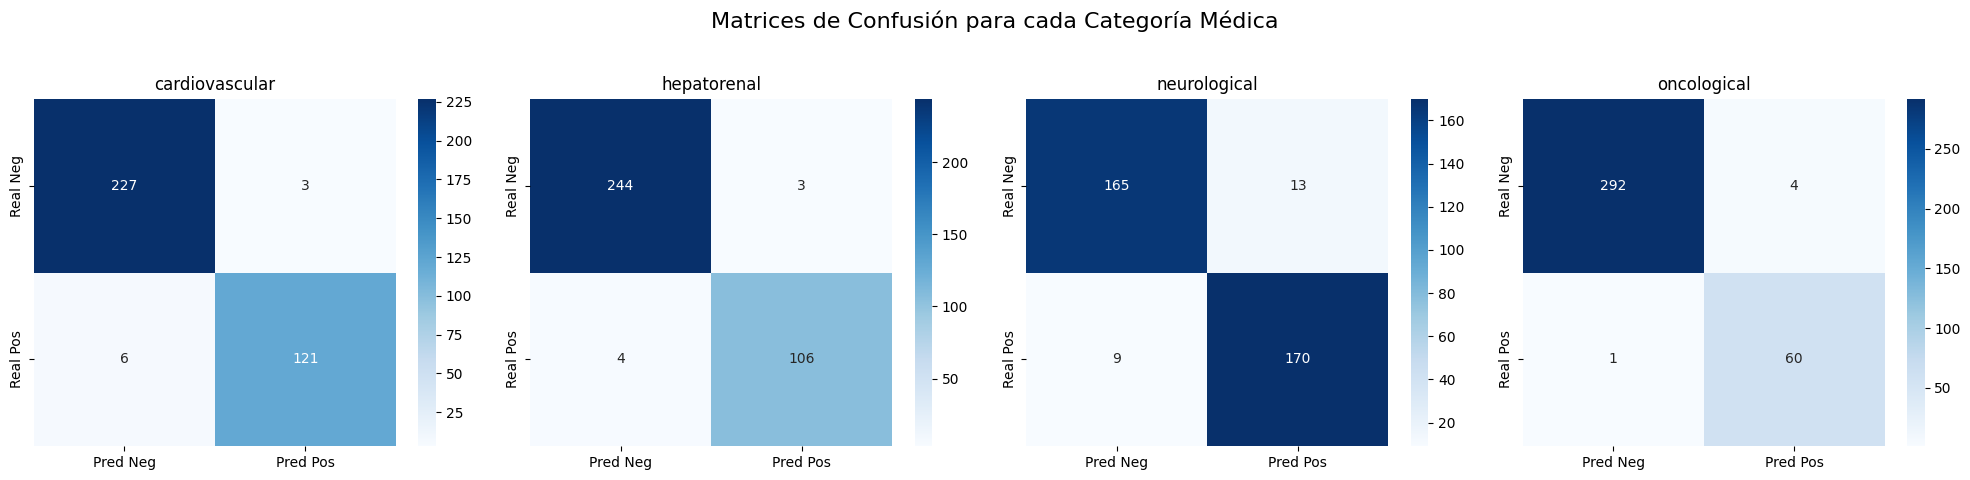


5. Guardando las predicciones en 'database/test_predictions.csv'...


OSError: [Errno 28] No space left on device

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.metrics import classification_report, multilabel_confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

# ==============================================================================
# ⚙️ PASO 1: CONFIGURACIÓN
# Define las rutas y los parámetros clave.
# ==============================================================================
MODEL_PATH = "models/scibert_uncased/"
TEST_DATA_PATH = "data\processedtest_set.csv"
OUTPUT_PREDICTIONS_PATH = "data\processed\test_predictions.csv"

# !!! AJUSTA ESTAS VARIABLES SEGÚN TU DATASET !!!
# El nombre de la columna que contiene el texto (título + resumen)
TEXT_COLUMN = 'text' 
# La lista de columnas que son tus etiquetas/categorías
LABEL_COLUMNS = ['cardiovascular','hepatorenal','neurological', 'oncological']

# Umbral para convertir probabilidades en etiquetas (0 o 1).
# Si tienes umbrales optimizados del paso de HPO, ¡ponlos aquí!
PREDICTION_THRESHOLD = 0.5 # O usa tus umbrales optimizados, ej: np.array([0.94, 0.39, ...])

# ==============================================================================
# 💾 PASO 2: CARGAR DATOS, MODELO Y TOKENIZADOR
# ==============================================================================
print("1. Cargando datos y modelo...")

# Cargar el conjunto de datos de prueba
try:
    test_df = pd.read_csv(TEST_DATA_PATH)
    # Asegúrate de que las columnas de etiquetas sean numéricas
    for col in LABEL_COLUMNS:
        test_df[col] = pd.to_numeric(test_df[col], errors='coerce')
    test_df.dropna(subset=LABEL_COLUMNS, inplace=True) # Elimina filas con etiquetas no válidas
except FileNotFoundError:
    print(f"Error: No se encontró el archivo de datos en '{TEST_DATA_PATH}'")
    # Detener la ejecución si el archivo no existe
    exit()


# Cargar el modelo y el tokenizador guardados
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"   - Usando dispositivo: {device}")

model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).to(device)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

print("   - ¡Datos y modelo cargados exitosamente!")


# ==============================================================================
# 📦 PASO 3: PREPARAR DATOS PARA LA PREDICCIÓN
# ==============================================================================
print("\n2. Tokenizando el conjunto de prueba...")

# Tokenizar el texto
test_encodings = tokenizer(test_df[TEXT_COLUMN].tolist(), truncation=True, padding=True, max_length=512)
true_labels = test_df[LABEL_COLUMNS].values

# Crear un Dataset de PyTorch para el Trainer
class InferenceDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

test_dataset = InferenceDataset(test_encodings)


# ==============================================================================
# 🚀 PASO 4: REALIZAR INFERENCIA
# ==============================================================================
print("\n3. Realizando predicciones en el conjunto de prueba...")

# Usamos el Trainer de Hugging Face para una inferencia eficiente (maneja batching y GPU)
training_args = TrainingArguments(
    output_dir='./results',          
    per_device_eval_batch_size=16, # Ajusta según la VRAM de tu GPU
    do_train=False,
    do_eval=False,
    do_predict=True,
    fp16=torch.cuda.is_available(), # Usa precisión mixta si hay GPU
)

trainer = Trainer(model=model, args=training_args)
predictions = trainer.predict(test_dataset)

# Los logits son las salidas crudas del modelo
logits = predictions.predictions


# ==============================================================================
# 📊 PASO 5: PROCESAR PREDICCIONES Y MOSTRAR MÉTRICAS
# ==============================================================================
print("\n4. Calculando y mostrando métricas de rendimiento...")

# Convertir logits a probabilidades usando la función sigmoide (ideal para multi-etiqueta)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

probabilities = sigmoid(logits)

# Aplicar el umbral para obtener las etiquetas predichas finales (0 o 1)
predicted_labels = (probabilities >= PREDICTION_THRESHOLD).astype(int)

# --- Métrica 1: Reporte de Clasificación por Clase ---
print("\n" + "="*50)
print("📊 REPORTE DE CLASIFICACIÓN POR CLASE")
print("="*50)
report = classification_report(
    true_labels, 
    predicted_labels, 
    target_names=LABEL_COLUMNS,
    zero_division=0
)
print(report)

# --- Métrica 2: Métricas F1 Globales y Accuracy ---
print("\n" + "="*50)
print("🌍 MÉTRICAS GLOBALES")
print("="*50)
f1_micro = f1_score(true_labels, predicted_labels, average='micro', zero_division=0)
f1_macro = f1_score(true_labels, predicted_labels, average='macro', zero_division=0)
f1_weighted = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
subset_accuracy = accuracy_score(true_labels, predicted_labels)

print(f"  - F1-Score (Micro):   {f1_micro:.4f}")
print(f"  - F1-Score (Macro):   {f1_macro:.4f}")
print(f"  - F1-Score (Weighted):{f1_weighted:.4f}  <-- Métrica principal de la hackathon")
print(f"  - Subset Accuracy:    {subset_accuracy:.4f} (proporción de predicciones 100% correctas)")


# --- Métrica 3: Matrices de Confusión por Clase ---
print("\n" + "="*50)
print("🌀 MATRICES DE CONFUSIÓN POR CLASE")
print("="*50)
# Para multi-etiqueta, generamos una matriz por cada clase

OUTPUT_DIR = "results/model"
os.makedirs(OUTPUT_DIR, exist_ok=True)

conf_matrices = multilabel_confusion_matrix(true_labels, predicted_labels)

fig, axes = plt.subplots(1, len(LABEL_COLUMNS), figsize=(20, 5))
fig.suptitle('Matrices de Confusión para cada Categoría Médica', fontsize=16)

for i, matrix in enumerate(conf_matrices):
    label = LABEL_COLUMNS[i]
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Pred Neg', 'Pred Pos'],
                yticklabels=['Real Neg', 'Real Pos'])
    axes[i].set_title(label)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Guardar la figura completa en la carpeta
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrices.png"))

# (Opcional) Mostrar en pantalla
plt.show()


# ==============================================================================
# 📄 PASO 6: GUARDAR PREDICCIONES
# ==============================================================================
print(f"\n5. Guardando las predicciones en '{OUTPUT_PREDICTIONS_PATH}'...")

# Crear un DataFrame con las predicciones y guardarlo
predictions_df = pd.DataFrame(predicted_labels, columns=[f'{col}_pred' for col in LABEL_COLUMNS])
results_df = pd.concat([test_df.reset_index(drop=True), predictions_df], axis=1)
results_df.to_csv(OUTPUT_PREDICTIONS_PATH, index=False)

print("\n🎉 ¡Evaluación completada exitosamente!")

1. Cargando modelo y tokenizador...
   - Usando dispositivo: cpu
   - ¡Modelo y tokenizador cargados exitosamente!

2. Cargando conjuntos de datos de validación y prueba...

   - Tokenizando 357 muestras...
   - Realizando inferencia...


c:\Users\samue\anaconda3\envs\deepxde_env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



3. Buscando umbrales óptimos en el conjunto de validación...
   - Umbrales encontrados:
{
  "cardiovascular": 0.1,
  "hepatorenal": 0.39,
  "neurological": 0.77,
  "oncological": 0.84
}

4. Evaluando el modelo en el conjunto de prueba con los umbrales encontrados...

   - Tokenizando 357 muestras...
   - Realizando inferencia...


c:\Users\samue\anaconda3\envs\deepxde_env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



📊 REPORTE DE CLASIFICACIÓN POR CLASE (CON UMBRALES ÓPTIMOS)
                precision    recall  f1-score   support

cardiovascular       0.98      0.96      0.97       127
   hepatorenal       0.97      0.96      0.97       110
  neurological       0.94      0.95      0.95       179
   oncological       0.94      0.98      0.96        61

     micro avg       0.96      0.96      0.96       477
     macro avg       0.96      0.96      0.96       477
  weighted avg       0.96      0.96      0.96       477
   samples avg       0.97      0.98      0.97       477


🌍 MÉTRICAS GLOBALES (CON UMBRALES ÓPTIMOS)
   - F1-Score (Micro):    0.9592
   - F1-Score (Macro):    0.9608
   - F1-Score (Weighted): 0.9592  <-- Métrica principal
   - Subset Accuracy:     0.9020

🌀 MATRICES DE CONFUSIÓN POR CLASE


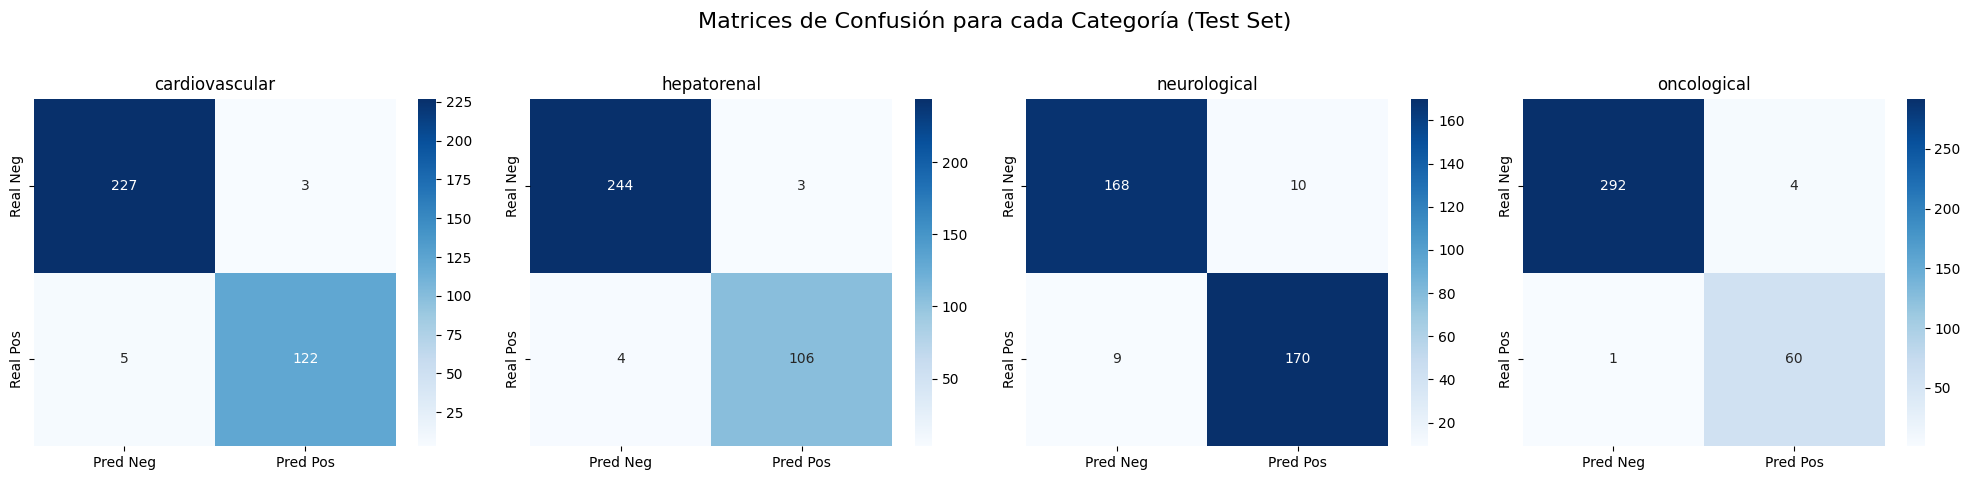


5. Guardando las predicciones finales en 'database/test_predictions_with_optimal_thresholds.csv'...

🎉 ¡Proceso completado exitosamente!


In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.metrics import classification_report, multilabel_confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import json

# ==============================================================================
# ⚙️ PASO 1: CONFIGURACIÓN
# Define las rutas y los parámetros clave.
# ==============================================================================
MODEL_PATH = "models/scibert_uncased/"
# !!! AÑADE LA RUTA A TU CONJUNTO DE VALIDACIÓN !!!
VALIDATION_DATA_PATH = "data\processed\val_set.csv" 
TEST_DATA_PATH = "data\processed\test_set.csv"
OUTPUT_PREDICTIONS_PATH = "data\processed\test_predictions_with_optimal_thresholds.csv"

# El nombre de la columna que contiene el texto (título + resumen)
TEXT_COLUMN = 'text' 
# La lista de columnas que son tus etiquetas/categorías
LABEL_COLUMNS = ['cardiovascular','hepatorenal','neurological', 'oncological']

# ==============================================================================
# 💾 PASO 2: CARGAR MODELO Y TOKENIZADOR
# Esto solo se hace una vez para ahorrar memoria.
# ==============================================================================
print("1. Cargando modelo y tokenizador...")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"   - Usando dispositivo: {device}")

try:
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).to(device)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
    print("   - ¡Modelo y tokenizador cargados exitosamente!")
except OSError:
    print(f"Error: No se encontró el modelo en la ruta '{MODEL_PATH}'. Asegúrate de que la ruta sea correcta.")
    exit()


# ==============================================================================
# 헬 FUNCIÓN 1: OBTENER PREDICCIONES DE UN DATAFRAME (VERSIÓN CORREGIDA)
# Encapsula la lógica de tokenización e inferencia para poder reutilizarla.
# ==============================================================================

# Primero, define una clase Dataset que devuelva diccionarios
class InferenceDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        # Devuelve un diccionario para cada muestra
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

def obtener_predicciones(df, text_col, label_cols):
    """Tokeniza un DataFrame y devuelve las probabilidades y etiquetas verdaderas."""
    print(f"\n   - Tokenizando {len(df)} muestras...")
    # Tokeniza toda la lista de textos a la vez
    encodings = tokenizer(df[text_col].tolist(), truncation=True, padding=True, max_length=512)
    
    # Usa la clase de Dataset personalizada
    dataset = InferenceDataset(encodings)
    
    args = TrainingArguments(
        output_dir='./temp_results',
        per_device_eval_batch_size=16,
        do_predict=True,
        fp16=torch.cuda.is_available(),
        report_to="none", # Evita warnings de W&B
    )
    
    trainer = Trainer(model=model, args=args)
    
    print(f"   - Realizando inferencia...")
    raw_predictions = trainer.predict(dataset)
    
    # Convertir logits a probabilidades
    logits = raw_predictions.predictions
    probabilities = 1 / (1 + np.exp(-logits)) # Función Sigmoide
    
    true_labels = df[label_cols].values if all(col in df.columns for col in label_cols) else None
    
    return probabilities, true_labels




# ==============================================================================
# 🎯 FUNCIÓN 2: ENCONTRAR UMBRALES ÓPTIMOS
# Usa el conjunto de validación para encontrar el mejor umbral por clase.
# ==============================================================================
def encontrar_umbrales_optimos(y_true, y_pred_probs, class_names):
    """Encuentra los umbrales óptimos por clase para maximizar el F1-score."""
    print("\n3. Buscando umbrales óptimos en el conjunto de validación...")
    umbrales_optimos = {}
    for i, name in enumerate(class_names):
        mejor_f1 = 0.0
        mejor_umbral = 0.5
        for umbral in np.arange(0.1, 0.91, 0.01):
            preds = (y_pred_probs[:, i] >= umbral).astype(int)
            f1 = f1_score(y_true[:, i], preds, zero_division=0)
            if f1 > mejor_f1:
                mejor_f1 = f1
                mejor_umbral = umbral
        umbrales_optimos[name] = round(mejor_umbral, 2)
    print("   - Umbrales encontrados:")
    print(json.dumps(umbrales_optimos, indent=2))
    return umbrales_optimos

# ==============================================================================
# 📊 FUNCIÓN 3: EVALUAR RENDIMIENTO
# Calcula y muestra todas las métricas usando umbrales específicos.
# ==============================================================================
def evaluar_rendimiento(y_true, y_pred_probs, umbrales, class_names):
    """Calcula y muestra un reporte completo de métricas de clasificación."""
    # Aplicar umbrales optimizados para obtener etiquetas finales
    umbrales_array = np.array([umbrales[name] for name in class_names])
    predicted_labels = (y_pred_probs >= umbrales_array).astype(int)

    print("\n" + "="*50)
    print("📊 REPORTE DE CLASIFICACIÓN POR CLASE (CON UMBRALES ÓPTIMOS)")
    print("="*50)
    print(classification_report(y_true, predicted_labels, target_names=class_names, zero_division=0))

    print("\n" + "="*50)
    print("🌍 MÉTRICAS GLOBALES (CON UMBRALES ÓPTIMOS)")
    print("="*50)
    f1_micro = f1_score(y_true, predicted_labels, average='micro', zero_division=0)
    f1_macro = f1_score(y_true, predicted_labels, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, predicted_labels, average='weighted', zero_division=0)
    subset_accuracy = accuracy_score(y_true, predicted_labels)
    print(f"   - F1-Score (Micro):    {f1_micro:.4f}")
    print(f"   - F1-Score (Macro):    {f1_macro:.4f}")
    print(f"   - F1-Score (Weighted): {f1_weighted:.4f}  <-- Métrica principal")
    print(f"   - Subset Accuracy:     {subset_accuracy:.4f}")

    print("\n" + "="*50)
    print("🌀 MATRICES DE CONFUSIÓN POR CLASE")
    print("="*50)
    conf_matrices = multilabel_confusion_matrix(y_true, predicted_labels)
    fig, axes = plt.subplots(1, len(class_names), figsize=(20, 5))
    fig.suptitle('Matrices de Confusión para cada Categoría (Test Set)', fontsize=16)
    for i, matrix in enumerate(conf_matrices):
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                    xticklabels=['Pred Neg', 'Pred Pos'], yticklabels=['Real Neg', 'Real Pos'])
        axes[i].set_title(class_names[i])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    return predicted_labels

# ==============================================================================
# 🚀 PASO 3: EJECUCIÓN DEL FLUJO PRINCIPAL
# ==============================================================================

# --- Cargar Datos de Validación y Test ---
print("\n2. Cargando conjuntos de datos de validación y prueba...")
try:
    validation_df = pd.read_csv(VALIDATION_DATA_PATH)
    test_df = pd.read_csv(TEST_DATA_PATH)
    # Limpieza básica
    validation_df.dropna(subset=LABEL_COLUMNS + [TEXT_COLUMN], inplace=True)
    test_df.dropna(subset=LABEL_COLUMNS + [TEXT_COLUMN], inplace=True)
except FileNotFoundError as e:
    print(f"Error: No se encontró el archivo de datos: {e.filename}")
    exit()

# --- Etapa de Validación: Encontrar Umbrales ---
val_probs, val_labels = obtener_predicciones(validation_df, TEXT_COLUMN, LABEL_COLUMNS)
umbrales_optimos = encontrar_umbrales_optimos(val_labels, val_probs, LABEL_COLUMNS)

# --- Etapa de Prueba: Evaluación Final ---
print("\n4. Evaluando el modelo en el conjunto de prueba con los umbrales encontrados...")
test_probs, test_labels = obtener_predicciones(test_df, TEXT_COLUMN, LABEL_COLUMNS)
final_predictions = evaluar_rendimiento(test_labels, test_probs, umbrales_optimos, LABEL_COLUMNS)

# ==============================================================================
# 📄 PASO 4: GUARDAR PREDICCIONES FINALES
# ==============================================================================
print(f"\n5. Guardando las predicciones finales en '{OUTPUT_PREDICTIONS_PATH}'...")
predictions_df = pd.DataFrame(final_predictions, columns=[f'{col}_pred' for col in LABEL_COLUMNS])
results_df = pd.concat([test_df.reset_index(drop=True), predictions_df], axis=1)
results_df.to_csv(OUTPUT_PREDICTIONS_PATH, index=False)

print("\n🎉 ¡Proceso completado exitosamente!")

In [3]:
print(umbrales_optimos)

{'cardiovascular': 0.1, 'hepatorenal': 0.39, 'neurological': 0.77, 'oncological': 0.84}
